In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [8]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [9]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

cifar_val_x = torch.empty((3, 32, 32, len(cifar10_val)), device=device)
cifar_val_y = torch.empty(len(cifar10_val), dtype=torch.long, device=device)

for i, (img, label) in enumerate(cifar10_val):
    cifar_val_x[:, :, :, i] = img
    cifar_val_y[i] = label

cifar_val_x = cifar_val_x.view(3, -1)

Files already downloaded and verified
Files already downloaded and verified


In [16]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_val=None, Y_pred=None):
        if Y_val is None:
            Y_val = self.last_val
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_val, torch.Tensor):
            Y_val = Y_val.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision': precision_score(Y_val, Y_pred, average='weighted'),
            'recall': recall_score(Y_val, Y_pred, average='weighted'),
            'f1': f1_score(Y_val, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_val, Y_pred),
            'classification_report': classification_report(Y_val, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
    def plot_training(self, title: str):
        loss_hist = self.train_loss_hist.cpu().detach().numpy()
        accuracy_hist = self.train_accuracy_hist.cpu().detach().numpy()
        validation_accuracy_hist = self.validation_accuracy_hist.cpu().detach().numpy()
        
        fig, ax = plt.subplots(1,2, sharex=True)
        fig.suptitle(title)
        ax[0].set_title('Training Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].plot(loss_hist, label='Training Loss')
        
        
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(accuracy_hist, label='Training Accuracy')
        ax[1].plot(validation_accuracy_hist, label='Validation Accuracy')
        
        plt.legend()
        plt.show()
    def plot_confusion_matrix(self, title):
        if self.last_results is None:
            self.get_results()
        cm = self.last_results['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(title)
        
        
        
        
        
                
    
import time
from math import floor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PerceptronClassifier(Classifier):
    def __init__(self, input_dim=0, output_dim = 0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        self.stack_list = [nn.Flatten(), nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.append(nn.Linear(hidden_layers[-1], output_dim))
        self.stack = nn.Sequential(*self.stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs: int,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        alpha: float,
        loss_fn: nn.Module = nn.CrossEntropyLoss(),
        optimizer: nn.Module = torch.optim.SGD,
        print_epoch: int = 10,
        **optimizer_kwargs,
    ):
        self.train_loss_hist = torch.zeros(epochs).to(device)
        self.train_accuracy_hist = torch.zeros(epochs).to(device)
        self.validation_accuracy_hist = torch.zeros(epochs).to(device)
        
        
        optimizer = optimizer(self.parameters(), lr=alpha, **optimizer_kwargs)
        training_time = 0
        for epoch in range(epochs):
            self.train()
            
            start_time = time.time()
            train_loss = 0
            train_correct = torch.zeros(1).to(device)
            
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                train_correct += (Y_pred.argmax(dim=1) == Y_batch).sum()
            training_time += time.time() - start_time
            
            self.train_accuracy_hist[epoch] = train_correct/len(train_loader.dataset)
            self.train_loss_hist[epoch] = train_loss/len(train_loader)
            
            val_correct = torch.zeros(1).to(device)
            self.eval()
            with torch.no_grad():
                Y_pred_eval = torch.zeros(len(test_loader.dataset)).to(device)
                
                idx = 0
                for X_val_batch, Y_val_batch in test_loader:
                    X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
                    batch_size = X_val_batch.size(0)
                    Y_pred = self.predict(X_val_batch)
                    Y_pred_eval[idx:idx + batch_size] = Y_pred
                    val_correct += (Y_pred == Y_val_batch).sum()
                    idx += batch_size
                    
                self.validation_accuracy_hist[epoch] = val_correct/len(test_loader.dataset)
            epoch_time = time.time() - start_time
            
                    
                
        
            if epoch % print_epoch == 0:
                rem_time = (epochs - epoch)*epoch_time / 60
                rem_time_str = f'{floor(rem_time):02}:{floor((rem_time - floor(rem_time))*60):02}'
                print(f'Epoch {epoch}: Training Loss: {(train_loss/len(train_loader))}, Training Accuracy: {(train_correct/len(train_loader.dataset)).item()}, Validation Accuracy: {(val_correct/len(test_loader.dataset)).item()}, Estimated Time Remaining: {rem_time_str}')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_val = torch.tensor(test_loader.dataset.targets)
        print(f'\nTraining Time: {training_time} seconds\n')

            
            


Using device: cuda


In [20]:

retrain = False

if retrain:
    perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[64, 32, 16], output_dim=10).to(device=device)
    perceptron.train_model(
        epochs=20,
        train_loader=train_loader,
        test_loader=test_loader,
        alpha=0.01,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=1.0,
        weight_decay = 0.001
    )
    pickle = torch.save(perceptron, 'models/perceptron.pt')
else:
    perceptron = torch.load('models/perceptron.pt')



Epoch 0: Training Loss: 2.148395222623635, Training Accuracy: 0.2223999947309494, Validation Accuracy: 0.29789999127388, Estimated Time Remaining: 04:34
Epoch 1: Training Loss: 1.8588589347536912, Training Accuracy: 0.339959979057312, Validation Accuracy: 0.38439998030662537, Estimated Time Remaining: 04:20
Epoch 2: Training Loss: 1.7015948277300277, Training Accuracy: 0.3947399854660034, Validation Accuracy: 0.4113999903202057, Estimated Time Remaining: 04:01
Epoch 3: Training Loss: 1.6246684560995273, Training Accuracy: 0.4199399948120117, Validation Accuracy: 0.4351999759674072, Estimated Time Remaining: 03:57
Epoch 4: Training Loss: 1.5647436005380146, Training Accuracy: 0.44057998061180115, Validation Accuracy: 0.44200000166893005, Estimated Time Remaining: 03:31
Epoch 5: Training Loss: 1.5120596423783266, Training Accuracy: 0.4609600007534027, Validation Accuracy: 0.45809999108314514, Estimated Time Remaining: 03:19
Epoch 6: Training Loss: 1.4638219283669807, Training Accuracy: 0

/tmp/ipykernel_3727/4121892279.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


Accuracy: 0.4933
Precision: 0.4982036274497342
Recall: 0.4933
F1: 0.48210309623743286
Confusion_matrix:
[[576  30  31  12  26  11  44  31 178  61]
 [ 28 571   6  19   5  10  62  18  82 199]
 [102  11 272  53 106  69 253  82  32  20]
 [ 55   7  60 242  39 170 289  66  25  47]
 [ 49  13  90  34 300  42 322 104  27  19]
 [ 37   8  59 159  62 330 182 103  37  23]
 [ 17  15  41  43  52  26 743  23  17  23]
 [ 29  16  24  44  65  69  84 595  20  54]
 [ 77  57  11  12  12  25  32  13 705  56]
 [ 42 124   2  24  11  14  47  52  85 599]]
Classification_report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1000
           1       0.67      0.57      0.62      1000
           2       0.46      0.27      0.34      1000
           3       0.38      0.24      0.29      1000
           4       0.44      0.30      0.36      1000
           5       0.43      0.33      0.37      1000
           6       0.36      0.74      0.49      1000
         

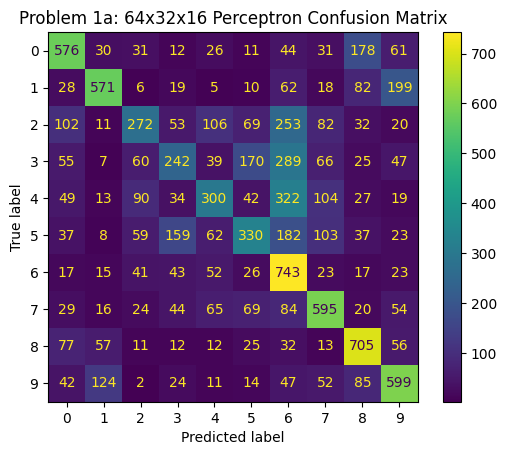

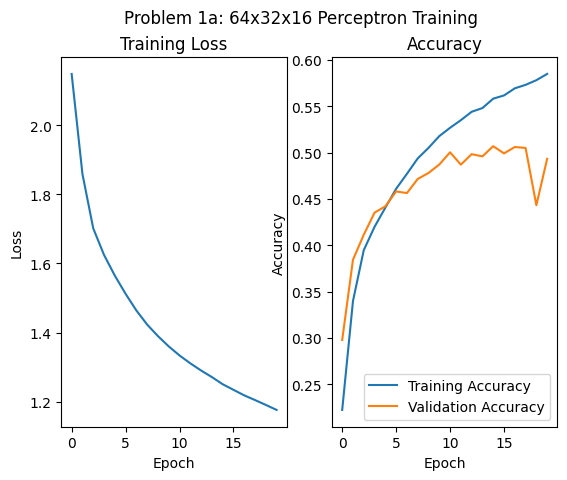

In [21]:
perceptron.print_results()
perceptron.plot_confusion_matrix('Problem 1a: 64x32x16 Perceptron Confusion Matrix')

perceptron.plot_training('Problem 1a: 64x32x16 Perceptron Training')

Epoch 0: Training Loss: 2.306191827025255, Training Accuracy: 0.10830000042915344, Validation Accuracy: 0.13289999961853027, Estimated Time Remaining: 04:48
Epoch 1: Training Loss: 2.2658282490947363, Training Accuracy: 0.15060000121593475, Validation Accuracy: 0.16249999403953552, Estimated Time Remaining: 04:36
Epoch 2: Training Loss: 2.137969131207527, Training Accuracy: 0.1975799947977066, Validation Accuracy: 0.21769998967647552, Estimated Time Remaining: 04:25
Epoch 3: Training Loss: 2.0152174185608964, Training Accuracy: 0.24039998650550842, Validation Accuracy: 0.25839999318122864, Estimated Time Remaining: 04:03
Epoch 4: Training Loss: 1.9116717875766023, Training Accuracy: 0.29235997796058655, Validation Accuracy: 0.31369999051094055, Estimated Time Remaining: 04:17
Epoch 5: Training Loss: 1.825684707640382, Training Accuracy: 0.322160005569458, Validation Accuracy: 0.3425000011920929, Estimated Time Remaining: 03:33
Epoch 6: Training Loss: 1.7388353596258042, Training Accura

/tmp/ipykernel_3727/4121892279.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


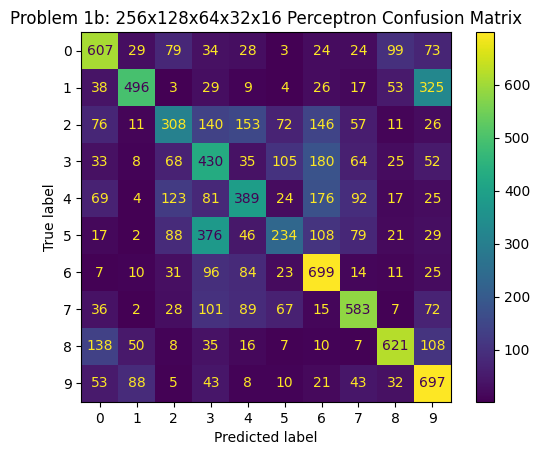

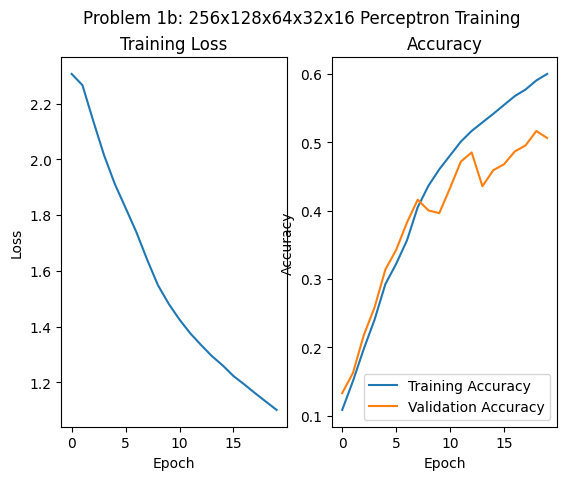

Comparing results:
accuracy: 2.5868878357029907 %
precision: 3.3741190699115093 %
recall: 2.5868878357029907 %
f1: 3.6853288038233654 %


In [23]:
retrain_complex = True

if retrain_complex:
    complex_perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[256, 128, 64, 32, 16], output_dim=10).to(device=device)
    complex_perceptron.train_model(
        epochs=20,
        train_loader=train_loader,
        test_loader=test_loader,
        alpha=0.01,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=1.0,
        weight_decay = 0.001
    )
    torch.save(complex_perceptron, 'models/complex_perceptron.pt')
    
else:
    complex_perceptron = torch.load('models/complex_perceptron.pt')

complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())


In [ ]:
complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())

In [26]:


path = 'data/Housing.csv'
housing = pd.DataFrame(pd.read_csv(path))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

df_train, df_val = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

X_train_df: pd.DataFrame = df_train
Y_train_df: pd.DataFrame = df_train.pop('price')

X_val_df: pd.DataFrame = df_val
Y_val_df: pd.DataFrame = df_val.pop('price')

sel_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']

X_train_df_filt = X_train_df[sel_vars]
X_val_df_filt = X_val_df[sel_vars]

X_train_np = X_train_df_filt.to_numpy()
X_test_np = X_val_df_filt.to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train_np)
X_train_np = scaler.transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

X_train_housing = torch.tensor(X_train_np, device=device).float()
Y_train_housing = torch.tensor(Y_train_df.to_numpy(), device=device).float()

X_val_housing = torch.tensor(X_test_np, device=device).float()
Y_val_housing = torch.tensor(Y_val_df.to_numpy(), device=device).float()




In [ ]:
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

class Regressor(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print(100 * (results1 - results2) / results1)
        
    def __init__(self, in_dim, out_dim, hidden_layers=[64,32], activation=nn.Tanh,):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.input_cols = []
        self.output_cols = []
        
        #Error Mode is a 5 bit integer, with each bit representing a feature
        # If the bit is 1, the feature is errored
        output_features = out_dim
        input_features = in_dim
        

        
        self.stack_list = [nn.Linear(input_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_features)])
        self.stack = nn.Sequential(*self.stack_list)
        
        
        
    def train(self, epochs, X_train, X_test, Y_train, Y_test, alpha=1e-2, loss_fn=nn.MSELoss(),):
        
        val_hist = np.zeros(epochs)
        train_hist = np.zeros(epochs)

        optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        for i in range(epochs):
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred.squeeze(), Y_train)
            loss.backward()
            optimizer.step()
            train_hist[i] = np.sqrt(loss.item())
            
            
            with torch.no_grad():
                Y_pred_val = self.forward(X_test)
                val_hist[i] = np.sqrt(loss_fn(Y_pred_val, Y_test).item())
            
        self.last_test = Y_test_tensor_p1
        self.last_pred = self.forward(X_test)
        self.last_score = val_hist[-1]
        
        self.last_epochs = epochs
        self.last_val_hist = val_hist
        self.last_train_hist = train_hist
    
    def plot_loss(self, title):
        
        plt.plot(range(self.last_epochs), self.last_val_hist, label='Validation Loss')
        plt.plot(range(self.last_epochs), self.last_train_hist, label='Training Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('RMS Loss')
        plt.legend()
        plt.show()
        
    def forward(self, x):
        return self.stack(x)
    
    def print_results(self):
        if self.last_score is None:
            raise ValueError('No results to print')
        print(f'MSE: {self.last_score:.2E}')
        
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_val=0.0):
        super(CustomMSELoss, self).__init__()
        self.lambda_val = lambda_val
    
    def forward(self, predictions, targets):

        m = targets.size(0)
        
        errors = predictions - targets
        mse_loss = (1 / (2*m)) * torch.sum(errors ** 2)
        

        

        total_loss = mse_loss
        
        return total_loss